# Install and Import Libraries

In [ ]:
!pip install datasets tensorflow pillow numpy

from datasets import load_dataset
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display


# Load a Subset of Dataset

In [ ]:
# Load IAM-line dataset
data = load_dataset("Teklia/IAM-line")

# Use only the first 10,000 characters for faster training
all_text = " ".join(data['train']['text']).lower()[:10000]
print("Sample dataset text:\n", all_text[:500])


Sample dataset text:
 put down a resolution on the subject and he is to be backed by mr. will nominating any more labour life peers m ps tomorrow. mr. michael foot has griffiths, m p for manchester exchange . is to be made at a meeting of labour a move to stop mr. gaitskell from 0m p for manchester exchange . a move to stop mr. gaitskell from nominating meeting of labour 0m ps tommorow . mr. michael any more labour life peers is to be made at a foot has put down a resolution on the subject and he is to be backed by m


# Prepare Sequences

In [ ]:
chars = sorted(list(set(all_text)))
char_to_index = {c:i for i,c in enumerate(chars)}
index_to_char = {i:c for i,c in enumerate(chars)}

seq_length = 40
step = 3

sequences = []
next_chars = []

for i in range(0, len(all_text) - seq_length, step):
    sequences.append(all_text[i:i+seq_length])
    next_chars.append(all_text[i+seq_length])

# Vectorize
X = np.zeros((len(sequences), seq_length, len(chars)), dtype=bool)
y = np.zeros((len(sequences), len(chars)), dtype=bool)

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_index[char]] = 1
    y[i, char_to_index[next_chars[i]]] = 1

print("Sequences prepared:", len(sequences))


Sequences prepared: 3320


# Build LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        88,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,611 (365.67 KB)

 Trainable params: 93,611 (365.67 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [ ]:
model.fit(X, y, batch_size=128, epochs=5)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 3.5346
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 2.9413
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 2.9154
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 2.9023
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 2.8719


# User Seed Text for Dynamic Generation

---



In [ ]:
user_seed = input(f"Enter at least {seq_length} characters as seed text:\n").lower()

if len(user_seed) < seq_length:
    user_seed = user_seed + " " * (seq_length - len(user_seed))
else:
    user_seed = user_seed[:seq_length]

print("Using seed text:\n", user_seed)


Enter at least 40 characters as seed text:
Hi i am Laxmidhar i amd from Uppal , Hyderabad
Using seed text:
 hi i am laxmidhar i amd from uppal , hyd


# Generate Dynamic Text

#


In [ ]:
def pick_next(preds, temperature=0.6):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(np.random.multinomial(1, preds, 1))

def generate_text(seed, length=150, temperature=0.6):
    result = seed
    for _ in range(length):
        x_pred = np.zeros((1, seq_length, len(chars)))
        for t, char in enumerate(result[-seq_length:]):
            if char in char_to_index:
                x_pred[0, t, char_to_index[char]] = 1
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = pick_next(preds, temperature)
        result += index_to_char[next_index]
    return result

generated_text = generate_text(user_seed)
print("Generated Text:\n", generated_text)


Generated Text:
 hi i am laxmidhar i amd from uppal , hyd o   n o  meeo ou r d t a gi so lmei e  ra    o  eipldeeiucro  ow l oaoget e roiido e a ssaaeaan  oee mtn euenl n   o eel  e l h e  he  olo tenilerscd


# Convert Text to Handwriting Image

In [32]:
def text_to_handwriting(text, font_path="MyHandwritingFont.ttf", max_width=800):
    font_size = random.randint(35, 45)  # Random size for realism
    font = ImageFont.truetype(font_path, font_size)
    words = text.split(" ")

    lines, line, width = [], "", 0
    for word in words:
        word_width = font.getbbox(word + " ")[2]
        if width + word_width <= max_width - 20:
            line += word + " "
            width += word_width
        else:
            lines.append(line)
            line = word + " "
            width = word_width
    lines.append(line)

    line_height = font.getbbox("A")[3] + 5
    img_height = line_height * len(lines) + 20
    img = Image.new("RGB", (max_width, img_height), "white")
    draw = ImageDraw.Draw(img)

    y = 10
    for line in lines:
        x = 10
        for char in line:
            char_width = font.getbbox(char)[2]
            draw.text((x, y + random.randint(-5,5)), char, fill="black", font=font)
            x += char_width + random.randint(0,5)
        y += line_height

    return img


# Generate and Display Handwriting

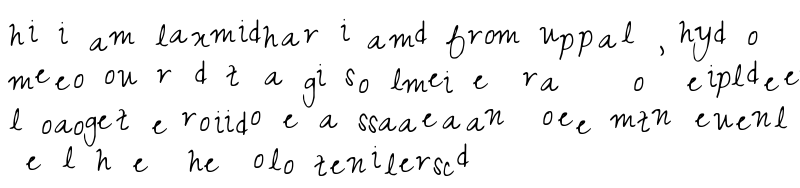

In [33]:
handwriting_img = text_to_handwriting(generated_text, font_path="MyHandwritingFont.ttf")
display(handwriting_img)  # Display inline in Colab
